# Data Analysis

In [1]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
from pymongo import MongoClient
import matplotlib as plt

In [2]:
plt.rcParams.update({'font.size': 24})

In [3]:
def parseEvent(line):
    values = line.split(', ')
    if(len(values) == 0):
        print('Skipping empty row.')
        return None
    event = { 'type': values.pop(0) }
    for value in values:
        keyValue = value.split(' = ')
        event[keyValue[0]] = keyValue[1].rstrip("\n\r")
    return event

In [ ]:
largeCSVFilePath = os.path.join('/', 'Users', 'deeps', 'Downloads', 'ldcc', 'ldcc.csv')
csvFile = open(largeCSVFilePath, 'r')
chunkSize = 1_000_000

client = MongoClient()
db = client.omocc
eventsCollection = db.events

events = []
lineNumber = 0
for line in csvFile:
    event = parseEvent(line)
    if (event is None):
        continue
    events.append(event)
    lineNumber += 1
    if (lineNumber % chunkSize == 0):
        print('Saving...')
        eventsCollection.insert_many(events)
        events = []
        print('Saved. Progress ' + str(lineNumber))
if len(events) > 0:
    eventsCollection.insert_many(events)
csvFile.close()
client.close()
print('Number of events processed: ' + str(lineNumber))

In [4]:
client = MongoClient()
db = client.omocc
cursor = db.events.aggregate([{
    '$group' : {
        '_id': '$type', 
        'count': {
            '$sum': 1 
        }
    }
}])
eventTypeCount = pd.DataFrame(list(cursor))
client.close()

In [5]:
eventTypeCount.set_index('_id', inplace=True, drop=True)
eventTypeCount.sort_values('count', ascending=False, inplace=True)
eventTypeCount

,count
_id,
insert,214832474
select,3179231
update,698783
delete,945
script_end,769
script_start,769
script_md5,666
commit,550
script_svn,444


In [6]:
def labelBars(plot):
    for p in plot.patches:
        plot.annotate(
            np.round(p.get_height(), decimals=2),
            (
                p.get_x() + p.get_width() / 2.,
                p.get_height()
            ),
            ha='center',
            va='center',
            xytext=(0, 10),
            textcoords='offset points'
     )

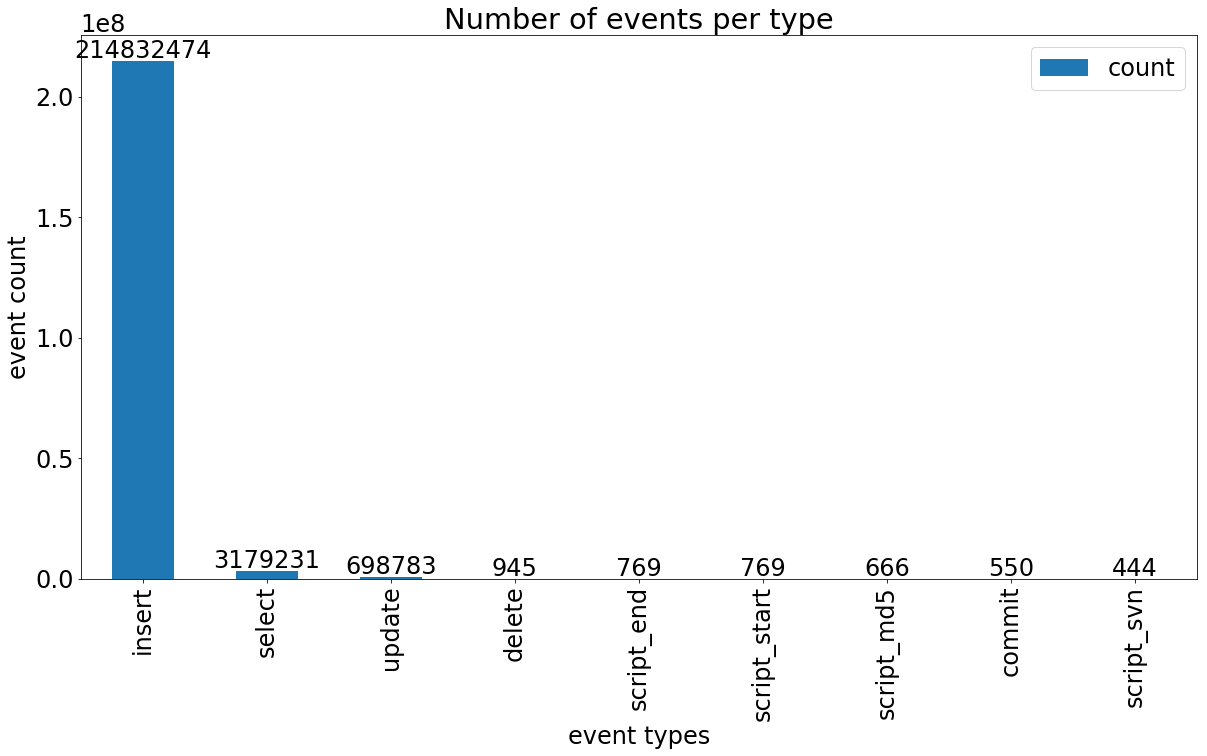

In [7]:
totalRows = eventTypeCount['count'].sum()
eventTypePlot = eventTypeCount.plot(
    kind='bar',
    figsize=(20, 10)
)
eventTypePlot.set(
    xlabel='event types',
    ylabel='event count',
    title='Number of events per type'
)
labelBars(eventTypePlot)

In [117]:
def getExampleForType(eventType, eventsCollection):
    return eventsCollection.find_one({
        'type': eventType
    })

client = MongoClient()
db = client.omocc
eventsCollection = db.events
eventExamples = eventTypeCount.index.map(lambda eventType: getExampleForType(eventType, eventsCollection))
client.close()
eventExamples = pd.DataFrame(list(eventExamples.flatten()))
eventExamples.drop(['_id'], axis='columns', inplace=True)
eventExamples.set_index('type', inplace=True, drop=True)

In [142]:
eventExamples

,d,db,md5,p,rev,rev1,rev2,s,status,tp,ts,u,url
type,,,,,,,,,,,,,
insert,112151559\n,db1,NaN,[unknown],NaN,NaN,NaN,NaN,NaN,30,1275324590,[unknown],NaN
select,[unknown]\n,db3,NaN,[unknown],NaN,NaN,NaN,NaN,NaN,65,1277196513,user1,NaN
update,[unknown]\n,db2,NaN,[unknown],NaN,NaN,NaN,NaN,NaN,16307,1277216945,script,NaN
delete,[unknown]\n,db3,NaN,[unknown],NaN,NaN,NaN,NaN,NaN,82980,1277728781,user7,NaN
script_start,NaN,NaN,NaN,NaN,NaN,NaN,NaN,script1\n,NaN,346,1277200697,NaN,NaN
script_end,NaN,NaN,NaN,NaN,NaN,NaN,NaN,script1\n,NaN,31179,1277232759,NaN,NaN
script_md5,NaN,NaN,ac6d06f21af087dcc171a82738b3af42\n,NaN,NaN,NaN,NaN,script1,NaN,1844086,1290211214,NaN,NaN
commit,NaN,NaN,NaN,NaN,1\n,NaN,NaN,NaN,NaN,0,1272882926,NaN,url1
script_svn,NaN,NaN,NaN,NaN,NaN,224,224\n,script12,svn-latest,1844085,1290211209,NaN,url171


In [153]:
client = MongoClient()
db = client.omocc
cursor = db.events.aggregate([{
    '$group' : {
        '_id': '$db', 
        'count': {
            '$sum': 1 
        }
    }
}])
dbValues = pd.DataFrame(list(cursor))
client.close()
dbValues.sort_values('count', ascending=False, inplace=True)

In [159]:
dbValues

,_id,count
1,db3,110800024
0,db2,107549456
2,db1,361953
3,None,3198


In [165]:
client = MongoClient()
db = client.omocc
cursor = db.events.aggregate([{
    '$group' : {
        '_id': { 
            '$trim': { 
                'input': '$p'
            }
        },
        'count': {
            '$sum': 1 
        }
    }
}])
pValues = pd.DataFrame(list(cursor))
client.close()
pValues.sort_values('count', ascending=False, inplace=True)

In [166]:
pValues.shape[0]

215

In [167]:
pValues.head()

,_id,count
168,[unknown],4230019
195,16,3720885
200,13,3257000
135,46,3236605
86,49,3162155


In [3]:
client = MongoClient()
db = client.omocc
cursor = db.events.aggregate([{
    '$group' : {
        '_id': { 
            '$trim': { 
                'input': '$u'
            }
        },
        'count': {
            '$sum': 1 
        }
    }
}])
uValues = pd.DataFrame(list(cursor))
client.close()
uValues.sort_values('count', ascending=False, inplace=True)

In [169]:
uValues.shape[0]

62

In [5]:
uValues['_id'].values

array(['script', 'triggers', 'user34', 'user53', '[unknown]', 'user4',
       'user1', 'user2', 'user44', 'user14', 'user9', 'user52', 'user19',
       'user8', 'user48', 'user32', 'user11', 'user22', None, 'user55',
       'user49', 'user21', 'user12', 'user16', 'user47', 'user5',
       'user50', 'user36', 'user13', 'user25', 'user6', 'user37',
       'user31', 'user30', 'user29', 'user42', 'user45', 'user54',
       'user43', 'user15', 'user58', 'user28', 'user39', 'user33',
       'user46', 'user7', 'user27', 'user51', 'user35', 'user41',
       'user23', 'user40', 'user38', 'user18', 'user26', 'user20',
       'user24', 'user56', 'user3', 'user10', 'user57', 'user17'],
      dtype=object)

In [171]:
client = MongoClient()
db = client.omocc
cursor = db.events.aggregate([{
    '$group' : {
        '_id': { 
            '$trim': { 
                'input': '$s'
            }
        },
        'count': {
            '$sum': 1 
        }
    }
}])
sValues = pd.DataFrame(list(cursor))
client.close()
sValues.sort_values('count', ascending=False, inplace=True)

In [172]:
sValues.shape[0]

4

In [173]:
sValues.head()

,_id,count
3,None,218711983
0,script12,888
1,script11,888
2,script1,872


In [5]:
client = MongoClient()
db = client.omocc
cursor = db.events.aggregate([{
    '$group' : {
        '_id': { 
            '$trim': { 
                'input': '$d'
            }
        },
        'count': {
            '$sum': 1 
        }
    }
}], allowDiskUse=True)
dValues = pd.DataFrame(list(cursor))
client.close()
dValues.sort_values('count', ascending=False, inplace=True)

In [6]:
dValues.shape[0]

107316152

In [7]:
dValues.head()

,_id,count
107316151,[unknown],3155452
0,None,3198
68282985,506476800,29
3621722,155555221,24
104117084,82333029,10


# Script for converting the log file into the MonPoly format

In [17]:
dbDescriptor = lambda event: 'user=' + event['u'] + ', database=' + event['db'] + ', p=' + event['p'] + ', d=' + event['d']
eventDescriptor = {
    'insert': dbDescriptor,
    'select': dbDescriptor,
    'update': dbDescriptor,
    'delete': dbDescriptor,
    'script_start': lambda event: 'script=' + event['s'],
    'script_end': lambda event: 'script=' + event['s'],
    'script_md5': lambda event: 'script=' + event['s'] + ', md5=' + event['md5'],
    'commit': lambda event: 'url=' + event['url'] + ', revision=' + event['rev'],
    'script_svn': lambda event: 'script=' + event['s'] + ', status=' + event['status'] + ', url=' + event['url'] + ', revision1=' + event['rev1'] + ', revision2=' + event['rev2'],
}
    

def buildMonPolyEvent(event):
    eventProperties = eventDescriptor[event['type']](event)
    return '@' + event['ts'] + ' ' + event['type'] + '(' + eventProperties + ')'

In [18]:
originalLogFilePath = os.path.join('/', 'Users', 'deeps', 'Downloads', 'ldcc', 'ldcc.csv')
monpolyLogFilePath = os.path.join('/', 'Users', 'deeps', 'Downloads', 'ldcc', 'ldcc-monpoly.csv')
originalLogFile = open(originalLogFilePath, 'r')
monpolyLogFile = open(monpolyLogFilePath, 'w')
for line in originalLogFile:
    event = parseEvent(line)
    monpolyEvent = buildMonPolyEvent(event)
    monpolyLogFile.write(monpolyEvent + '\n')
monpolyLogFile.close()
originalLogFile.close()

@1272882926 commit(url=url1, revision=1)
